# `TODO`  

``` HTML
---
[ANALYSE]   >> Average analysis results across subjects -- <DONE; CHECK!>
 
[ANALYSE]   >> Remove vertices with low confidence (using 'R2' values from the PRF results) -- <DONE>
[ANALYSE]   >> Distance calculations per grid -- <DONE>
[ANALYSE]   >> Divide metric into grids and compute distances with variance of groups -- <DONE>
[ANALYSE]   >> Find way to compute 'correlation' between space-metric space plots -- <DONE> (TSNE-PLOTS!)
[VISUALIZE] >> TSNE embedding in space-metric plot -- <DONE>
[VISUALIZE] >> Polar plots per functional pracellation -- <DONE>
[VISUALIZE] >> Create polar heatmap of distances from distance analysis on grids -- <DONE>
```

---

# Imports

In [345]:
import sys
import os

In [346]:
import math

In [347]:
from itertools import chain, cycle

---

In [348]:
import numpy as np

In [349]:
import pandas as pd

In [350]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [351]:
import seaborn as sns

In [352]:
import scipy as sc

In [353]:
from sklearn.manifold import TSNE

---

In [354]:
import mat73

---

In [355]:
import neuropythy as ny

In [356]:
import nibabel as nib

In [357]:
# import hcp_utils as hcp

---

---

In [358]:
import logging

In [359]:
import warnings

In [360]:
from IPython.display import display, display_html

In [361]:
from tqdm import tqdm

---

In [362]:
from utils import HCP_S3

## Config

In [363]:
# logging
logging.getLogger().setLevel(logging.INFO)

In [364]:
# warnings
warnings.filterwarnings('ignore')

# Constants

In [365]:
ANG_MESH = np.linspace(0, 360, 61)
ECC_MESH = np.logspace(0, 4, 9, base=2) - 1 # np.array([0., 2, 5, 8, 12, 16]) # 

In [366]:
I = 104416 # 1000610 # 999999

In [367]:
R2_THRESHOLD = 36 # >37 leads to error because of no values with R2 under some parcellation for some subject

In [368]:
ROI = ['V1', 'V2'] #, 'V3'] #, 'V4'] # ['V1d', 'V1v', 'V2d', 'V2v']

ROI_COLORS = dict(zip(ROI, sns.color_palette(n_colors=len(ROI))))
# ROI_MARKERS = dict(zip(ROI, ['*', 'X', 'o', None][:len(ROI])) 
# ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# ('*', '+', '-', '.', '/', 'O', 'X', '\', 'o', 'x', '|')

# Functions

## Lambda Functions

In [369]:
rectify = relu = lambda x, elbow=0.0, norm=1.0: (type(x) if type(x) is not np.ndarray else np.array)(np.c_[x, np.zeros_like(x)].max(axis=1)/norm)

## Data Manipulation Functions

In [370]:
def get_coors(sid=100610, volume_space='native', surface_mesh='fs_lr_low', surface_type='midthickness', msm_alignment_method='msmall', hemisphere='both', directory='hcp-subjects'):
    """ Gets the grayordinate coordinates of a subject for the given volume and surface space, surface type, surface alignment method, and hemisphere. 

    Example of files to get,
    - 100610/T1w/fsaverage_LR32k/100610.L.midthickness_MSMAll.32k_fs_LR.surf.gii
    - 100610/T1w/fsaverage_LR32k/100610.R.midthickness_MSMAll.32k_fs_LR.surf.gii
    - 100610/MNINonLinear/fsaverage_LR32k/100610.L.atlasroi.32k_fs_LR.shape.gii
    - 100610/MNINonLinear/fsaverage_LR32k/100610.R.atlasroi.32k_fs_LR.shape.gii

    Parameters
    ----------
    sid : int, optional
        Serial ID of the participant, by default 100610.
    volume_space : {'native', 'mni'}, optional
        The volume space for the coordinates, by default 'native'.
    surface_mesh : {'native', 'fs_lr_high', 'fs_lr_med', 'fs_lr_low'}, optional
        The surface mesh for the coordinates, by default 'native'.
    surface_type : {flat, white, pial, midthickness, sphere, inflated, very_inflated}, optional
        The surface type for the coordinates, by default 'midthickness'.
    msm_alignment_method: {'msmsulc', 'msmall', None}, optional
        The surface alignment method used by MSM, by default 'msmall'.
    hemisphere : {'left', 'right', 'both'}, optional
        The hemisphere to get coordinates for, by default 'both'.
    directory : str, optional
        The path to HCP subjects root directory under './data/', by default 'hcp-subjects'.

    Returns
    -------
    numpy.darray
        List of 3D coordinates of the requested surface; [left_hemisphere_vertices; right_hemisphere_cortices]. # ; subcortical_voxels.
    """
    
    if msm_alignment_method is None and not surface_mesh == 'native' and surface_type not in {'flat', 'sphere'}:
        logging.warning('`None` as MSM alignment method is only valid for native surface mesh (probably also only in MNI volume space)! Defaulting to MSMAll method.')
        msm_alignment_method = 'msmall'
    
    if surface_type != 'sphere' and volume_space == 'mni' and surface_mesh == 'native':
        raise ValueError('Only spherical surface type available for native surface mesh in MNI volume space!')
    
    if volume_space == 'native' and surface_mesh == 'fs_lr_high':
        raise ValueError('164k vertex high resolution Conte69 registered standard surface mesh only available in MNI volume space!')
    
    if volume_space == 'native' and surface_mesh == 'native':
        if msm_alignment_method == 'msmall':
            logging.warning('MSMAll alignment method not available for native surface mesh in native volume space! Using MSMSulc method instead.')
        logging.info('The method is not specified in the available files for native surface mesh in native volume space. Probably MSMSulc.')
        msm_alignment_method = None
    
    volume_space_label = {'native': 'T1w', 'mni': 'MNINonLinear'}[volume_space]
    surface_mesh_label = {'native': 'Native', 'fs_lr_high': '.', 'fs_lr_med': 'fsaverage_LR59k', 'fs_lr_low': 'fsaverage_LR32k'}[surface_mesh]
    surface_mesh_label_2 = {'native': 'native', 'fs_lr_high': '164k_fs_LR', 'fs_lr_med': '59k_fs_LR', 'fs_lr_low': '32k_fs_LR'}[surface_mesh]
    # msm_alignment_method_label = 
    if surface_type in {'flat', 'sphere'}:
        if msm_alignment_method == 'msmall':
            logging.warning(f'MSMAll alignment method not available for {surface_type} surface mesh! Using MSMSulc method instead.')
        logging.info('The method is not specified in the available files for flat and spherical meshes. Probably MSMSulc.')
        msm_alignment_method_label = ''
    elif surface_mesh == 'native':
        msm_alignment_method_label = {'msmsulc': '.MSMAll', 'msmall': '.MSMSulc', None: ''}[msm_alignment_method]
    elif surface_mesh == 'fs_lr_med':
        msm_alignment_method_label = {'msmsulc': '', 'msmall': '_1.6mm_MSMAll'}[msm_alignment_method]
    else:
        msm_alignment_method_label = {'msmsulc': '', 'msmall': '_MSMAll'}[msm_alignment_method]
    
    if hemisphere == 'both':
        lh_coors_file = f'{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.L.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii'
        # print(lh_coors_file)
        if not os.path.isfile(f'data/{directory}/{lh_coors_file}'):
            HCP_S3.download(f'HCP_1200/{lh_coors_file}', local=f'data/{directory}', trim=2)
        lh_coors = nib.load(f'data/{directory}/{lh_coors_file}').agg_data()[0]
        
        rh_coors_file = f'{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.R.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii'
        # print(rh_coors_file)
        if not os.path.isfile(f'data/{directory}/{rh_coors_file}'):
            HCP_S3.download(f'HCP_1200/{rh_coors_file}', local=f'data/{directory}', trim=2)
        rh_coors = nib.load(f'data/{directory}/{rh_coors_file}').agg_data()[0]
        
        
        lh_atlas_file = f'{sid}/MNINonLinear/{surface_mesh_label}/{sid}.L.atlasroi.{surface_mesh_label_2}.shape.gii'
        # print(lh_atlas_file)
        if not os.path.isfile(f'data/{directory}/{lh_atlas_file}'):
            HCP_S3.download(f'HCP_1200/{lh_atlas_file}', local=f'data/{directory}', trim=2)
        lh_atlas = nib.load(f'data/{directory}/{lh_atlas_file}').agg_data().astype(bool)
        
        rh_atlas_file = f'{sid}/MNINonLinear/{surface_mesh_label}/{sid}.R.atlasroi.{surface_mesh_label_2}.shape.gii'
        # print(rh_atlas_file)
        if not os.path.isfile(f'data/{directory}/{rh_atlas_file}'):
            HCP_S3.download(f'HCP_1200/{rh_atlas_file}', local=f'data/{directory}', trim=2)
        rh_atlas = nib.load(f'data/{directory}/{rh_atlas_file}').agg_data().astype(bool)
        
        return np.r_[lh_coors[lh_atlas], rh_coors[rh_atlas]], ['L'] * lh_atlas.sum() + ['R'] * rh_atlas.sum()
    
    else:
        hemisphere_label = {'left': 'L', 'right': 'R'}[hemisphere]
        
        h_coors_file = f'{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.{hemisphere_label}.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii'
        # print(h_coors_file)
        if not os.path.isfile(f'data/{directory}/{h_coors_file}'):
            HCP_S3.download(f'HCP_1200/{h_coors_file}', local=f'data/{directory}', trim=2)
        h_coors = nib.load(f'data/{directory}/{h_coors_file}').agg_data()[0]

        h_atlas_file = f'{sid}/MNINonLinear/{surface_mesh_label}/{sid}.{hemisphere_label}.atlasroi.{surface_mesh_label_2}.shape.gii'
        # print(h_atlas_file)
        if not os.path.isfile(f'data/{directory}/{h_atlas_file}'):
            HCP_S3.download(f'HCP_1200/{h_atlas_file}', local=f'data/{directory}', trim=2)
        h_atlas = nib.load(f'data/{directory}/{h_atlas_file}').agg_data().astype(bool)
        
        return h_coors[h_atlas], [hemisphere_label] * h_atlas.sum()

> `len(lh_coors) + len(rh_coors) + sum(lh_atlas) + sum(rh_atlas) - len(df)`  
>> $33114 = 32492 * 2 + 29696 + 29716 - 91282$

---

In [371]:
def filter_labels(df_, roi=ROI, merge_dorsal_ventral=True):
    """ Filter DataFrame with labels in `roi`.
    
    Parameters
    ----------
    df_ : pandas.DataFrame
        The DataFrame to filter.
    roi : array_like, optional
        The labels/regions of interest, by default `ROI`.
    merge_dorsal_ventral : bool, optional
        Whether to remove the intra-region separation, by default True.

    Returns
    -------
    pd.DataFrame
        The filtered DataFrame.
    """
    df_ = df_.dropna() # Not really required
    df__ = df_[df_[label].str.contains('|'.join(roi))] # df[df[label].isin(roi_1)]
    df__ = df__.sort_values(by=label, key=lambda col: col.str.lower())
    if merge_dorsal_ventral:
        df__[label] = df__[label].str.replace(r'\w*(V\d)\w*', lambda s: s.group(1), regex=True)
    return df__

In [372]:
def group(df_, root_groups, ang_mesh=ANG_MESH, ecc_mesh=ECC_MESH, aggr_func='mean'): # spatial_grid_spacing in mm
    """ Groups, and aggregates DataFrame in passed eccentricity and angular ranges using passed aggregation function, by parcel.

    Parameters
    ----------
    df_ : pandas.DataFrame
        The DataFrame to consolidate.
    root_groups: array_like or str
        Columns to group by before grouping by angular or eccentricity.
    ang_mesh : numpy.ndarray, optional
        The angular mesh to cut `df_['ang']` with, by default `ANG_MESH`.
    ecc_mesh : numpy.ndarray, optional
        The eccentricity mesh to cut `df_['ecc']` with, by default `ECC_MESH`.
    aggr_func : function or str, optional
        The aggregation function used to aggregate groups (vertices in mesh polygons), by default 'mean'.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame agregated in eccentricty and angular ranges, grouped by parcels.
    """
    def wrapper(df_grp):
        df_grp_ = df_grp.groupby([
            pd.cut(df_grp['ecc'], ecc_mesh, labels=ecc_mesh[1:].round(1)),
            pd.cut(df_grp['ang'], ang_mesh, labels=((ang_mesh[1:] + ang_mesh[:-1])/2).astype(int))
        ])
        if type(aggr_func) == str: # 'mean'
            return getattr(df_grp_, aggr_func)(numeric_only=True)
        elif callable(aggr_func): # lambda x: x.mean()
            return df_grp_.apply(aggr_func) # lambda x: aggr_func(x[x.notnull()])
    
    return df_.groupby(root_groups).apply(wrapper)

In [373]:
def l2(df_, roi_=ROI, shift_len=None):
    """ Computes distances between parcels.

    Parameters
    ----------
    df_ : pandas.DataFrame, optional
        DataFrame grouped by parcels and eccentricity/angles.
    roi_ : array-like
        Parcels in the passed DataFrame.
    shift_len : int or `None`, optional
        The number of groups available for each parcel, by default `None`.
        Is calculated automatically (`int(len(df_)/len(roi_))`) if `None`.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame with canonical directional distances ['dx', 'dy', 'dz'] and L2 distance between vertices (voxels) ['d'].
    """
    # TODO: Handle cases with entirely missing values under a parcel.
    shift_len = shift_len if shift_len is not None else int(len(df_)/len(roi_))
    diff = lambda x: (x - x.shift(-shift_len)).add_prefix('d')
    
    df_d = diff(df_) # [['dx', 'dy', 'dz']]
        
    df_d['d'] = np.sqrt(np.sum(df_d.pow(2), axis=1))
    # Improv.: https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    
    # Make sure that d values for NaN dx/dy/dz is NaN (won't happen but just in case)
    df_d['d'][df_d.isna().any(axis=1)] = np.nan
    
    df_d = df_d.iloc[:-shift_len]
    df_d.index = df_d.index.set_levels([f'{i} - {j}' for i, j in zip(roi_[:-1], roi_[1:])], level=0)
    
    return df_d # [['dx', 'dy', 'dz'] + ['d']]

## Printing and Plotting Functions

In [374]:
def display_side_by_side(*args, titles=cycle([''])):
    """ Display DataFrames side by side """
    display_html(''.join([fr"""
            <th style="text-align:center">
                <td style="vertical-align:top">
                    <h2 style="text-align: center;">{title}</h2>
                    {df_.to_html().replace('table', 'table style="display:inline"')}
                </td>
            </th>
        """ for df_, title in zip(args, chain(titles, cycle(['</br>'])))]), raw=True)

# Load Data

## PRF Results

In [375]:
data = mat73.loadmat('data/osfstorage-archive/prfresults.mat')

In [376]:
data.keys()

dict_keys(['allresults', 'ciftifsaveragebad', 'ciftifsaverageix', 'groupsubjectids', 'quants', 'subjectids'])

- `allresults` - is 91282 grayordinates x 6 quantities x 184 datasets x 3 model fits with the full set of pRF analysis results.  
- `quants` - is a 1 x 6 cell vector with a label for the 6 quantities: {'ang' 'ecc' 'gain' 'meanvol' 'R2' 'rfsize'}.  
- `subjectids` - is 184 x 1 with the 6-digit ID for each subject (both individual and group-average subjects).  
- `ciftifsaverageix` - is 327684 x 1 with indices into the 91282 CIFTI space. This indexing vector performs a nearest-neighbor mapping from CIFTI to FreeSurfer's fsaverage space. Note that some of the fsaverage vertices do not have a counterpart in the CIFTI space; these vertices are assigned a value of 1 in 'ciftifsaverageix'.  
- `ciftifsaveragebad` - is 327684 x 1 with logical values indicating which fsaverage vertices do not have a counterpart in the CIFTI space. These vertices should receive a NaN after performing the indexing-based mapping.  
- `groupsubjectids` - is a 1 x 3 cell vector indicating which subjects contributed to the special 999997, 999998, and 999999 group-average subjects, respectively. Each element is a vector of indices (in the range 1-181) in sorted order.

In [377]:
data["allresults"].shape

(91282, 6, 184, 3)

91282 grayordinates x 6 quantities x 184 datasets x 3 model fits

In [378]:
data["quants"]

['ang', 'ecc', 'gain', 'meanvol', 'R2', 'rfsize']

- `ang` is the angle of the estimated pRF location. Specifically, it is the angle that the center of the pRF has with respect to the positive x-axis. The range of values is 0-360 and the units are degrees. Note that when the estimated pRF is exactly at the center of gaze (i.e., eccentricity is exactly 0), then angle is ill-defined. Thus, we have explicitly set the angle to NaN for any case in which eccentricity is 0.  
- `ecc` is the eccentricity of the estimated pRF location. Specifically, it is the distance from the center of gaze to the center of the pRF. Values are greater than or equal to 0 and the units are degrees of visual angle.  
- `gain` is the BOLD response amplitude estimated in the model fit. The units are raw scanner units (same units as the time-series data in the CIFTI files). The value can be interpreted as the amplitude of the BOLD response that is predicted to result from 1 s of full-field visual stimulation.  
- `meanvol` is the mean signal intensity observed in the time-series data. The units are raw scanner units (same units as the time-series data in the CIFTI files). Note that some grayordinates have a mean signal intensity that are zero or negative, so be careful (e.g., if converting to percent BOLD signal change).  
- `R2` is the amount of variance (R-squared) in the time-series data explained by the pRF model. The values generally range from 0-100 and the units are percentages. Note that R-squared values are computed after projecting out low-order polynomials from both the time-series data and the model fit. Because of this step, R-squared values can sometimes drop below 0%.  
- `rfsize` is the size of the estimated pRF. Specifically, it is one standard deviation of a 2D Gaussian that describes the behavior of the grayordinate (see paper for details). Values are positive and the units are degrees of visual angle.

In [379]:
# Load standard atlases
atlases = mat73.loadmat('data/osfstorage-archive/atlas.mat')

In [380]:
print(atlases['wang2015labels'])

['Unknown', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']


In [381]:
label ='parcellation_label'

In [382]:
subjects = [s for s in data['subjectids'].astype(int) if s not in {999997, 999998, 999999}]

## DataFrames

In [383]:
df = pd.DataFrame(np.vstack(np.moveaxis(data['allresults'][:, :, [s in subjects for s in data['subjectids']], 0], -1, 0)), columns=data['quants'])
df['sid'] = np.repeat(subjects, (n_vertices:=data['allresults'].shape[0]))
df[label] = np.tile(np.array(atlases['wang2015labels'])[atlases['wang2015'].astype(int)], (n_subjects:=len(subjects)))

In [384]:
df[['x', 'y', 'z']] = np.nan
df['hemisphere'] = None
for sid in (pbar:=tqdm(subjects)):
    coors, hemisphere = get_coors(sid)
    df.loc[df.index[df['sid'] == sid][:len(coors)], ['x', 'y', 'z']] = coors # Chaining loc and iloc returns a copy!
    df.loc[df.index[df['sid'] == sid][:len(coors)], 'hemisphere'] = hemisphere # Chaining loc and iloc returns a copy!
    pbar.set_description(f'> {sid}')

> 995174: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:16<00:00, 10.83it/s]


In [385]:
df.head()

,ang,ecc,gain,meanvol,R2,rfsize,sid,parcellation_label,x,y,z,hemisphere
0,78.750000,13.656000,4.231637,11666.171875,0.071830,3.620387,100610,Unknown,-6.292804,-44.266945,36.105831,L
1,78.750000,13.656000,360.575104,11236.359375,0.528848,1.810193,100610,Unknown,-20.089428,-39.821842,57.238029,L
2,356.123291,0.041699,1.978915,12020.344727,0.258905,0.044100,100610,Unknown,-51.502712,-5.706688,38.448883,L
3,67.500000,9.640000,4.365994,11231.982422,1.421750,10.240000,100610,Unknown,-6.774565,16.997980,55.665588,L
4,302.340454,3.615990,25.726778,13231.762695,40.571110,1.205791,100610,V3A,-21.281158,-94.312286,17.565191,L


---

In [386]:
df_ = df.loc[df['R2'] > R2_THRESHOLD]

---

In [387]:
dfv = filter_labels(df_)

In [388]:
dfv.head()

,ang,ecc,gain,meanvol,R2,rfsize,sid,parcellation_label,x,y,z,hemisphere
12101511,216.479691,4.779871,36.300762,10855.157227,47.344929,1.749039,585256,V4,13.946315,-79.938545,-8.170120,R
6320939,1.047043,4.544993,58.741619,12573.267578,49.286442,1.589013,187345,V4,-26.233973,-67.230995,-7.025398,L
6320940,10.892009,4.431365,44.110413,10938.567383,37.079315,1.242355,187345,V4,-25.017820,-68.505974,-9.010578,L
6320943,68.752312,0.985099,45.806210,10510.902344,42.027561,0.305097,187345,V4,-15.301319,-73.063087,-9.539447,L
3612172,154.548004,2.335120,42.877491,12428.696289,42.083782,0.278240,158136,V4,20.457951,-83.639938,-3.710803,R


In [389]:
dfv_r = dfv[dfv['hemisphere'] == 'R']
dfv_l = dfv[dfv['hemisphere'] == 'L']

---

##### One Subject

In [390]:
# Taking the results corresponding to the pRF model fit based on all data of subject I
df_i = pd.DataFrame(data["allresults"][:, :, np.argwhere(data['subjectids'] == I).squeeze(), 0], columns=data['quants'])
df_i[label] = np.array(atlases['wang2015labels'])[atlases['wang2015'].astype(int)]

coors, hemisphere = get_coors(directory='.temp')

df_i[['x', 'y', 'z']] = np.nan
df_i['hemisphere'] = None
df_i.loc[:len(coors)-1, ['x', 'y', 'z']] = coors # df_i.loc[df_i.index[:len(coors)], ['x', 'y', 'z']] = coors
df_i.loc[:len(coors)-1, ['hemisphere']] = hemisphere # df_i.loc[df_i.index[:len(coors)], 'hemisphere'] = hemisphere

In [391]:
df_i.head()

,ang,ecc,gain,meanvol,R2,rfsize,parcellation_label,x,y,z,hemisphere
0,281.252930,7.967530,5.181196,11936.156250,1.049209,0.055746,Unknown,-6.292804,-44.266945,36.105831,L
1,191.250000,7.968000,1.690859,13644.246094,0.427991,0.640000,Unknown,-20.089428,-39.821842,57.238029,L
2,51.841434,6.294945,5.114536,13050.157227,1.843655,1.250500,Unknown,-51.502712,-5.706688,38.448883,L
3,23.488859,7.889767,5.288835,13172.202148,1.619774,0.055441,Unknown,-6.774565,16.997980,55.665588,L
4,12.089827,4.657740,51.880547,12230.550781,61.938530,1.268238,V3A,-21.281158,-94.312286,17.565191,L


---

In [392]:
df_i = df_i.loc[df_i['R2'] > R2_THRESHOLD]

---

`Neuropythy subject object`

---

In [393]:
dfv_i = filter_labels(df_i)

In [394]:
dfv_i.head()

,ang,ecc,gain,meanvol,R2,rfsize,parcellation_label,x,y,z,hemisphere
22390,44.087410,0.764038,53.822025,11633.125977,49.711372,0.161263,V4,-22.994864,-83.651764,-13.650750,L
52364,158.778275,2.569556,32.542015,10169.250000,48.679520,0.873540,V4,23.527687,-76.224396,0.783314,R
52363,187.465454,3.926378,39.397655,10382.576172,45.304264,1.320605,V4,26.024073,-73.832718,0.364141,R
52362,202.316223,5.535238,39.017876,10784.510742,41.281921,1.948116,V4,25.995584,-71.614220,-0.696496,R
52341,134.429932,2.763958,62.507504,10217.272461,60.675823,0.915045,V4,19.491467,-78.900253,2.235016,R


In [395]:
dfv_r_i = dfv_i[dfv_i['hemisphere'] == 'R']
dfv_l_i = dfv_i[dfv_i['hemisphere'] == 'L']

# Basic Visualisations

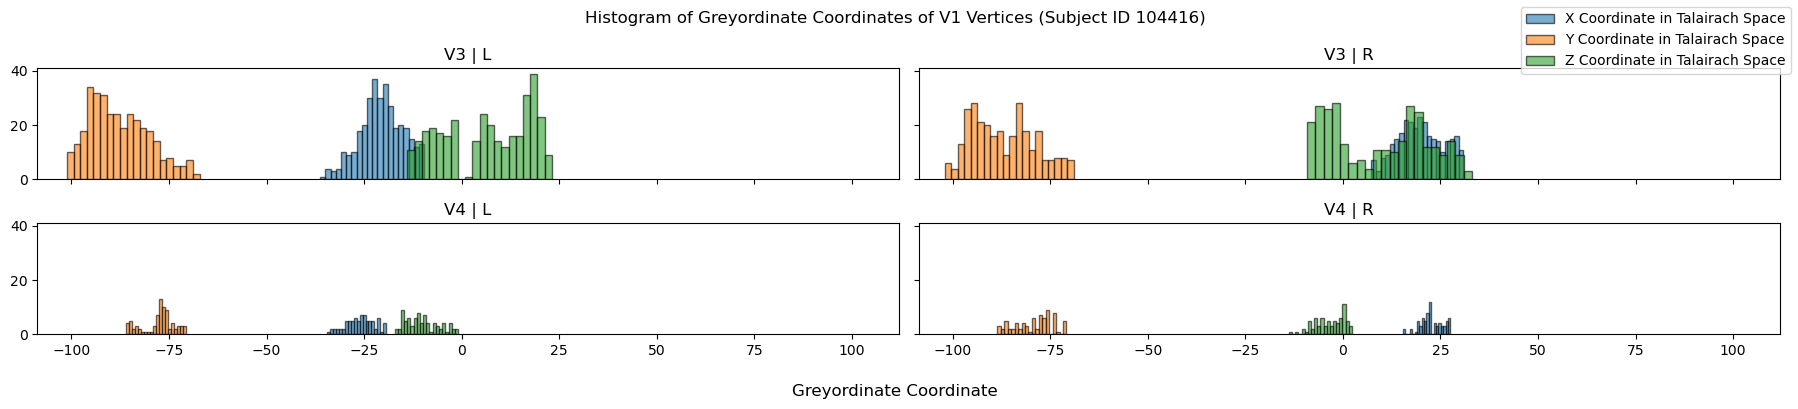

In [396]:
%matplotlib inline
fig, axs = plt.subplots(len(ROI), 2, figsize=(18, 2*len(ROI)), sharex=True, sharey=True)

for i, label_i in enumerate(ROI):
    for j, hemisphere in enumerate(['L', 'R']):
        for coordinate_axis in ['x', 'y', 'z']:
            axs[i][j].hist(dfv_i[(dfv_i[label].str.contains(label_i)) & (dfv_i['hemisphere'] == hemisphere)][coordinate_axis],
                       bins=20, edgecolor='black', alpha=0.6,
                       label=f'{f"{coordinate_axis.upper()} Coordinate in Talairach Space" if i == j == 0 else ""}'
            )
            axs[i][j].set_title(f'{label_i} | {hemisphere}')

axs[0][0].set_xlim([None, 112])

fig.supxlabel('Greyordinate Coordinate')
fig.suptitle(f'Histogram of Greyordinate Coordinates of V1 Vertices (Subject ID {I})')
fig.legend()

plt.tight_layout()

---

In [397]:
metric = 'ecc'
metric_limit = 3

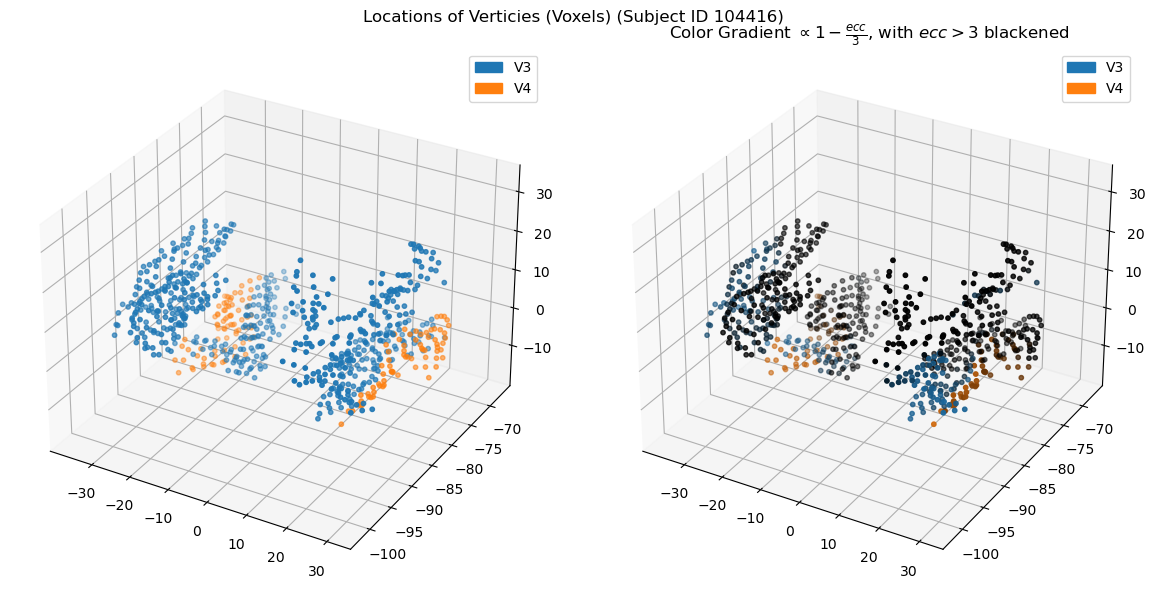

In [398]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

axs[0].scatter(*dfv_i[['x', 'y', 'z']].T.to_numpy(), s=10, c=[ROI_COLORS[pl] for pl in dfv_i[label]])
axs[0].legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in ROI_COLORS.items()])

for roi_label in ROI:
    axs[1].scatter(*dfv_i[dfv_i[label] == roi_label][['x', 'y', 'z']].T.to_numpy(),
               s=10, #marker=roi_markers_[roi_label],
               c=[np.array(ROI_COLORS[roi_label]) * relu(1 - met/metric_limit) for met in dfv_i[dfv_i[label] == roi_label][metric]]
    )
axs[1].legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in ROI_COLORS.items()])
axs[1].set_title(fr'Color Gradient $\propto 1 - \frac{{{metric}}}{{{metric_limit}}}$, with ${metric} > {metric_limit}$ blackened')

fig.suptitle(f'Locations of Verticies (Voxels) (Subject ID {I})')
plt.tight_layout()

---

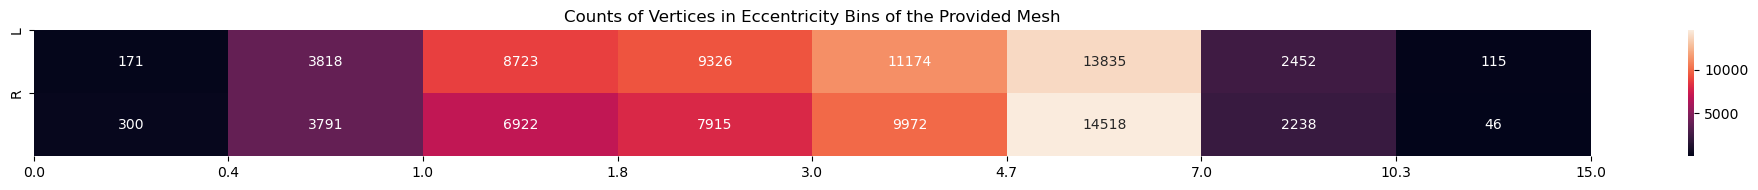

In [399]:
dfv_ = dfv.groupby(['hemisphere',
                    pd.cut(dfv['ecc'], ECC_MESH, labels=ECC_MESH[1:].round(1))
                   ]).count()

plt.figure(figsize=(20, 2))
sns.heatmap([dfv_[label].loc[s] for s in ('L', 'R')], annot=True, fmt='g')
plt.yticks((0, 1), ('L', 'R'))
plt.xticks(list(range(len(ECC_MESH)))[::1], ECC_MESH.round(1)[::1])

plt.title('Counts of Vertices in Eccentricity Bins of the Provided Mesh')
plt.tight_layout()

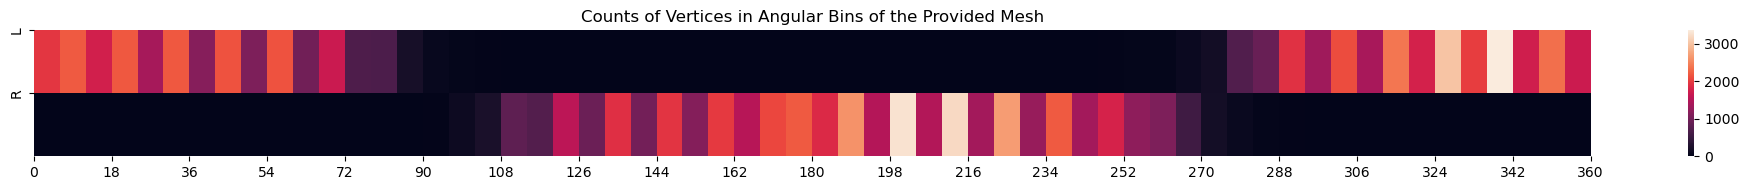

In [400]:
dfv_ = dfv.groupby(['hemisphere',
                    pd.cut(dfv['ang'], ANG_MESH, labels=((ANG_MESH[1:] + ANG_MESH[:-1])/2).astype(int))
                   ]).count()

plt.figure(figsize=(20, 2))
sns.heatmap([dfv_[label].loc[s] for s in ('L', 'R')])
plt.yticks((0, 1), ('L', 'R'))
plt.xticks(list(range(len(ANG_MESH)))[::3], ANG_MESH.astype(int)[::3])

plt.title('Counts of Vertices in Angular Bins of the Provided Mesh')
plt.tight_layout()

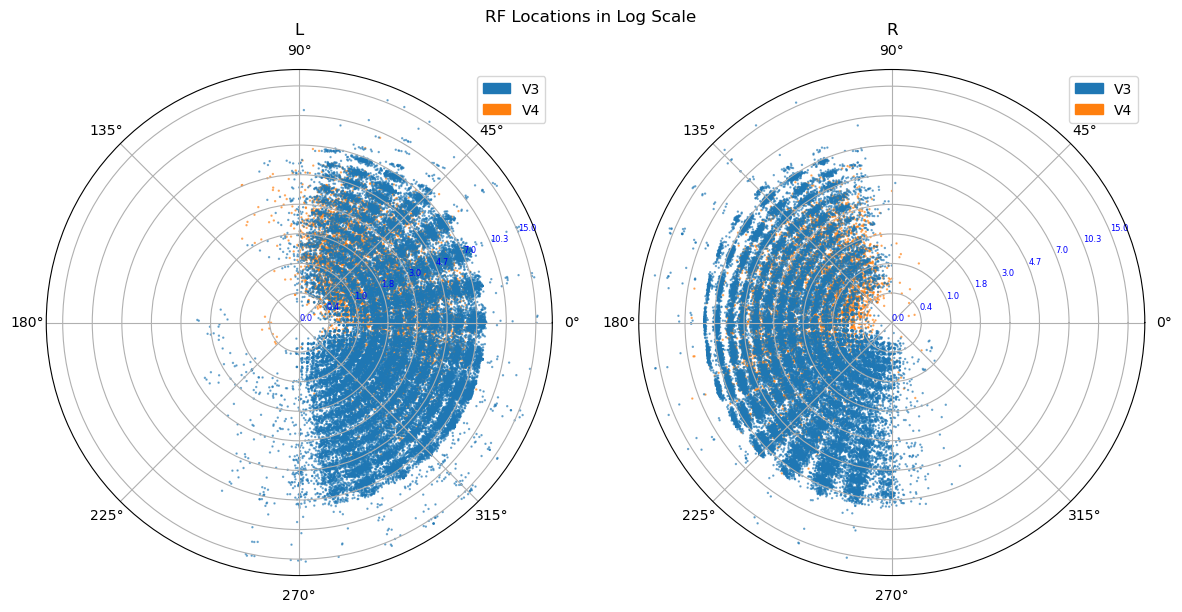

In [401]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'polar'})

axs[0].scatter(np.pi/180*dfv_l['ang'], np.log(1 + dfv_l['ecc']), s=0.5, c=[ROI_COLORS[l] for l in dfv_l[label]], alpha=0.6)
axs[0].legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in ROI_COLORS.items()])
axs[0].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[0].set_title('L')

axs[1].scatter(np.pi/180*dfv_r['ang'], np.log(1 + dfv_r['ecc']), s=0.5, c=[ROI_COLORS[l] for l in dfv_r[label]], alpha=0.6)
axs[1].legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in ROI_COLORS.items()])
axs[1].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[1].set_title('R')

# ax.set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
# ax.set_thetagrids([0])

fig.suptitle('RF Locations in Log Scale')
plt.tight_layout()

---

In [402]:
# TODO:
## Investigate the mismatch in graph densities between the above and the distance heatmaps.

---

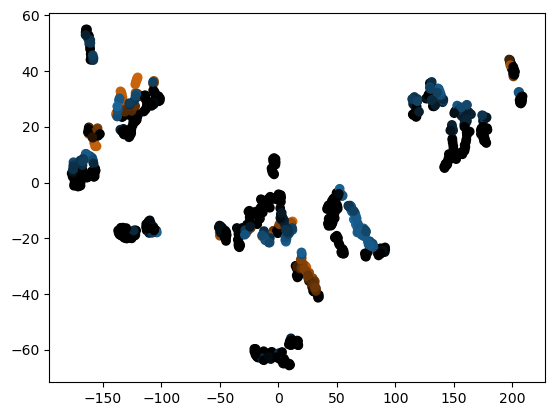

In [403]:
plt.scatter(*TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10).fit_transform(dfv_i[['x', 'y', 'z', 'ecc', 'ang']]).T, # , 'rfsize'
            c=np.array([ROI_COLORS[pl] for pl in dfv_i[label]]) * relu(1 - dfv_i['ecc']/3)[:, None]);

# Analysis

In [404]:
def wrapper(dfv_):
    dfv_p  = group(dfv_, label)[['x', 'y', 'z']]
    dfv_d  = l2(dfv_p)
    dfv_d_ = dfv_d.reset_index().pivot(columns='ang', index='ecc', values='d')
    return dfv_d_

In [405]:
dfv_l_d = dfv_l.groupby('sid').apply(wrapper)
dfv_r_d = dfv_r.groupby('sid').apply(wrapper)

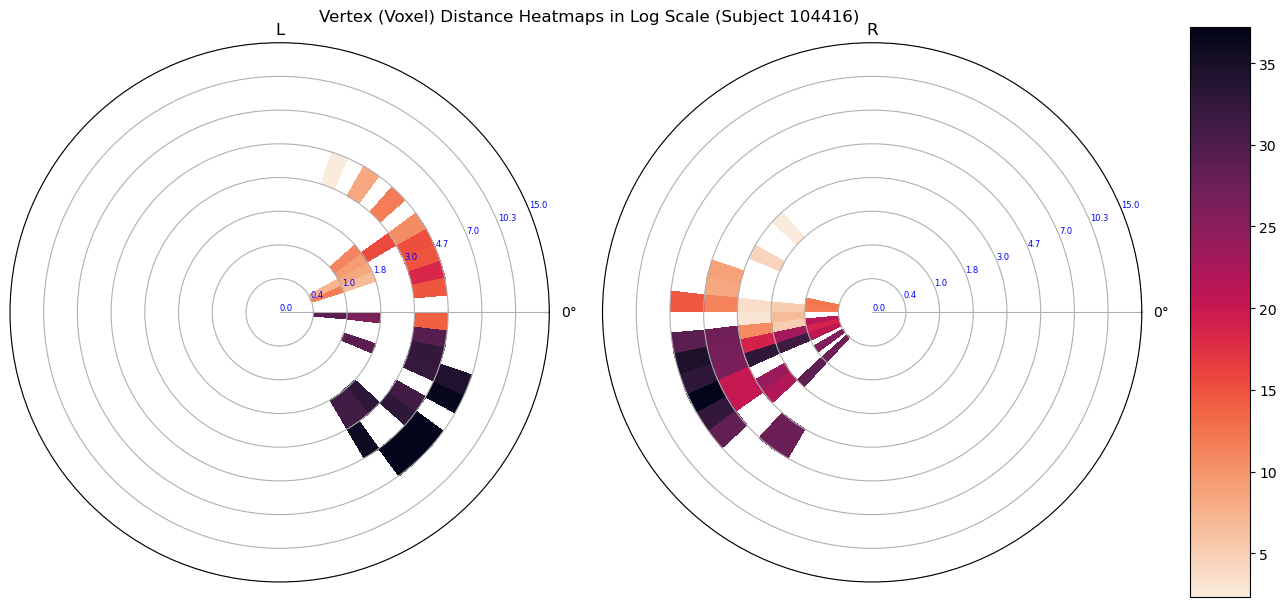

In [406]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'polar'})

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[0])
pplot_1 = axs[0].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_l_d.loc[100610].to_numpy(), cmap=sns.cm.rocket_r) 
# axs[0].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[0].set_thetagrids([0])
axs[0].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[0].grid()
axs[0].set_title('L')
# fig.colorbar(pplot_1, ax=axs[0])

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[1])
pplot_2 = axs[1].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_r_d.loc[100610].to_numpy(), cmap=sns.cm.rocket_r) 
# axs[1].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[1].set_thetagrids([0])
axs[1].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[1].grid()
axs[1].set_title('R')
# fig.colorbar(pplot_2, ax=axs[1])

fig.colorbar(pplot_2, cax=fig.add_axes([1, 0, 0.05, 0.95]))

fig.suptitle(f'Vertex (Voxel) Distance Heatmaps in Log Scale (Subject {I})')
plt.tight_layout()

In [407]:
dfv_l_d_ = dfv_l_d.groupby(level=1).mean()
dfv_r_d_ = dfv_r_d.groupby(level=1).mean()

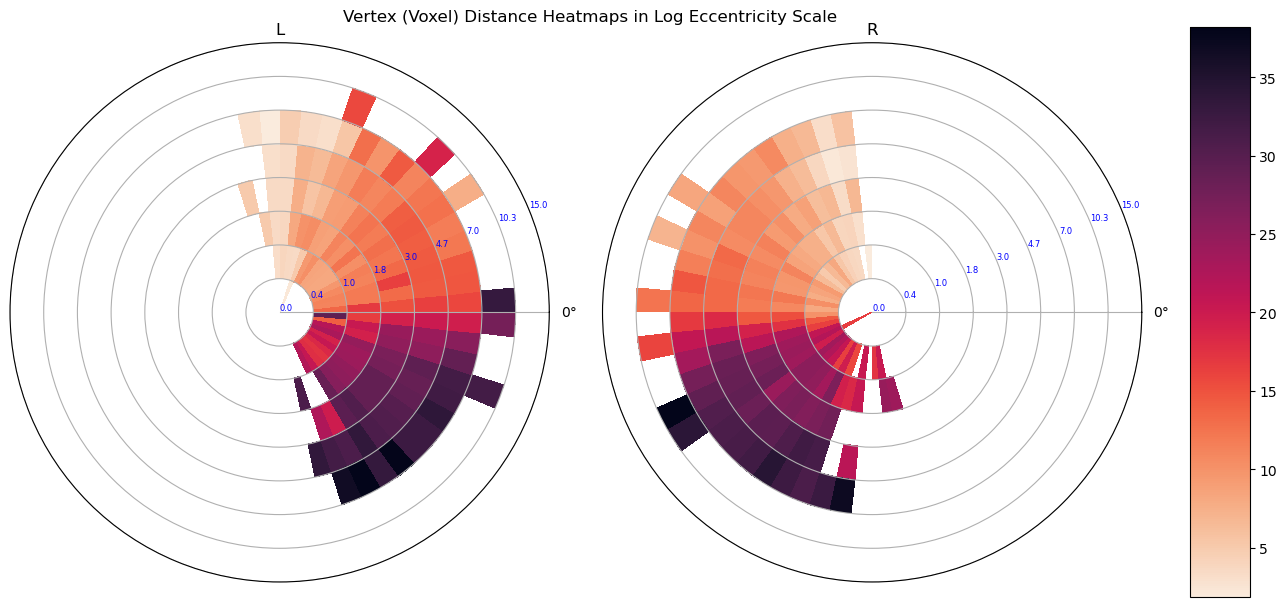

In [408]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'polar'})

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[0])
pplot_1 = axs[0].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_l_d_.to_numpy(), cmap=sns.cm.rocket_r) 
# axs[0].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[0].set_thetagrids([0])
axs[0].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[0].grid()
axs[0].set_title('L')
# fig.colorbar(pplot_1, ax=axs[0])

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[1])
pplot_2 = axs[1].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_r_d_.to_numpy(), cmap=sns.cm.rocket_r) 
# axs[1].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[1].set_thetagrids([0])
axs[1].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[1].grid()
axs[1].set_title('R')
# fig.colorbar(pplot_2, ax=axs[1])

fig.colorbar(pplot_2, cax=fig.add_axes([1, 0, 0.05, 0.95]))

fig.suptitle('Vertex (Voxel) Distance Heatmaps in Log Eccentricity Scale')
plt.tight_layout()

In [409]:
dfv_l_c_ = dfv_l_d.groupby(level=1).count()
dfv_r_c_ = dfv_r_d.groupby(level=1).count()

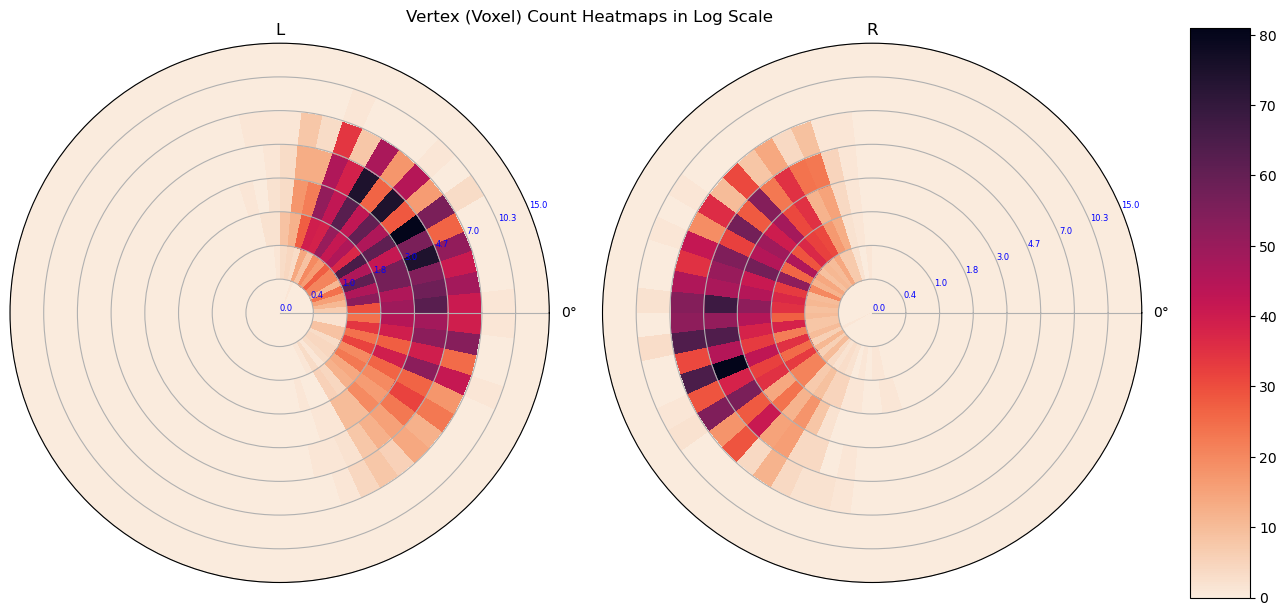

In [410]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'polar'})

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[0])
pplot_1 = axs[0].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_l_c_.to_numpy(), cmap=sns.cm.rocket_r) 
# axs[0].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[0].set_thetagrids([0])
axs[0].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[0].grid()
axs[0].set_title('L')
# fig.colorbar(pplot_1, ax=axs[0])

# sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[1])
pplot_2 = axs[1].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_r_c_.to_numpy(), cmap=sns.cm.rocket_r) 
# axs[1].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
axs[1].set_thetagrids([0])
axs[1].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
axs[1].grid()
axs[1].set_title('R')
# fig.colorbar(pplot_2, ax=axs[1])

fig.colorbar(pplot_2, cax=fig.add_axes([1, 0, 0.05, 0.95]))

fig.suptitle('Vertex (Voxel) Count Heatmaps in Log Scale')
plt.tight_layout()

#

---

In [444]:
def show(pair, label=None):
    if type(pair) == int:
        dfv_l_d__ = globals()[f'dfv_l_d_{pair}']
        dfv_r_d__ = globals()[f'dfv_r_d_{pair}']
    elif type(pair) == list:
        dfv_l_d__, dfv_r_d__ = pair
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'polar'})

    # sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[0])
    pplot_1 = axs[0].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_l_d__.to_numpy(), cmap=sns.cm.rocket_r) 
    # axs[0].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
    axs[0].set_thetagrids([0])
    axs[0].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
    axs[0].grid()
    axs[0].set_title('L')
    # fig.colorbar(pplot_1, ax=axs[0])

    # sns.heatmap(dfv_l_d, cmap=sns.cm.rocket_r, ax=axs[1])
    pplot_2 = axs[1].pcolormesh(np.pi/180*ANG_MESH, np.log(1 + ECC_MESH), dfv_r_d__.to_numpy(), cmap=sns.cm.rocket_r) 
    # axs[1].set_thetagrids(ANG_MESH[:-1], [fr'${ANG_MESH[i]}^{{\circ}}$' if i%3 == 0 else None for i in range(len(ANG_MESH[:-1]))])
    axs[1].set_thetagrids([0])
    axs[1].set_rgrids(np.log(1 + ECC_MESH), ECC_MESH.round(1), color='b', fontsize=6)
    axs[1].grid()
    axs[1].set_title('R')
    # fig.colorbar(pplot_2, ax=axs[1])

    fig.colorbar(pplot_2, cax=fig.add_axes([1, 0, 0.05, 0.95]))

    fig.suptitle(f'Vertex (Voxel) Distance Heatmaps in Log Eccentricity Scale | {label if label else f"V{str(pair)[0]} - V{str(pair)[1]}"}')
    plt.tight_layout()

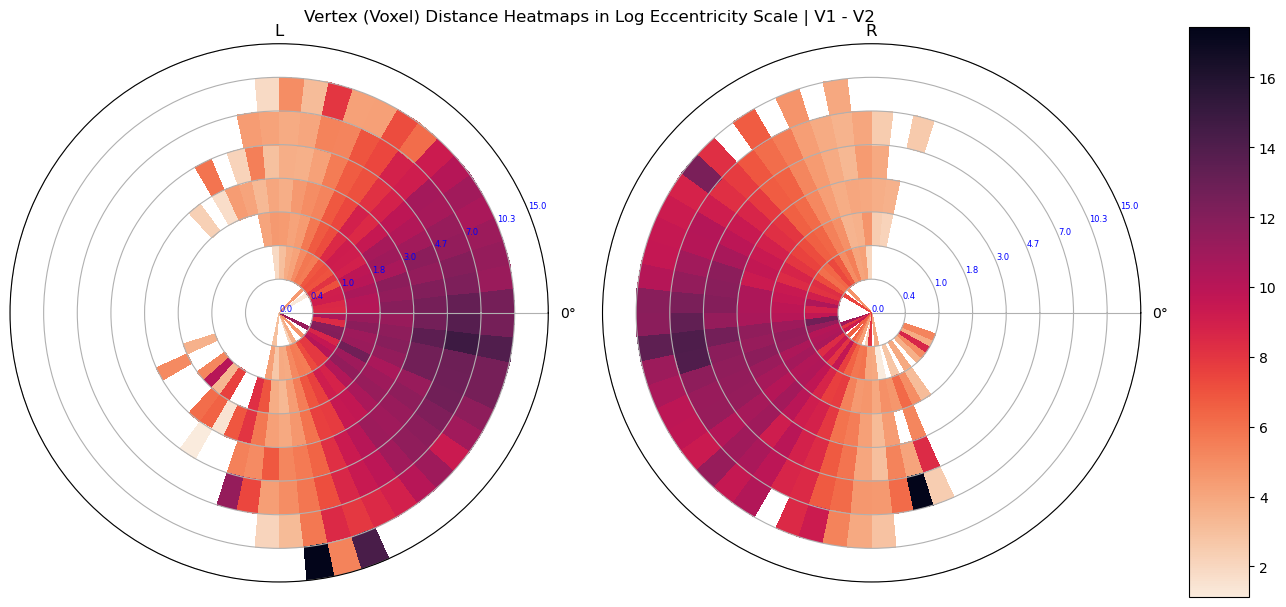

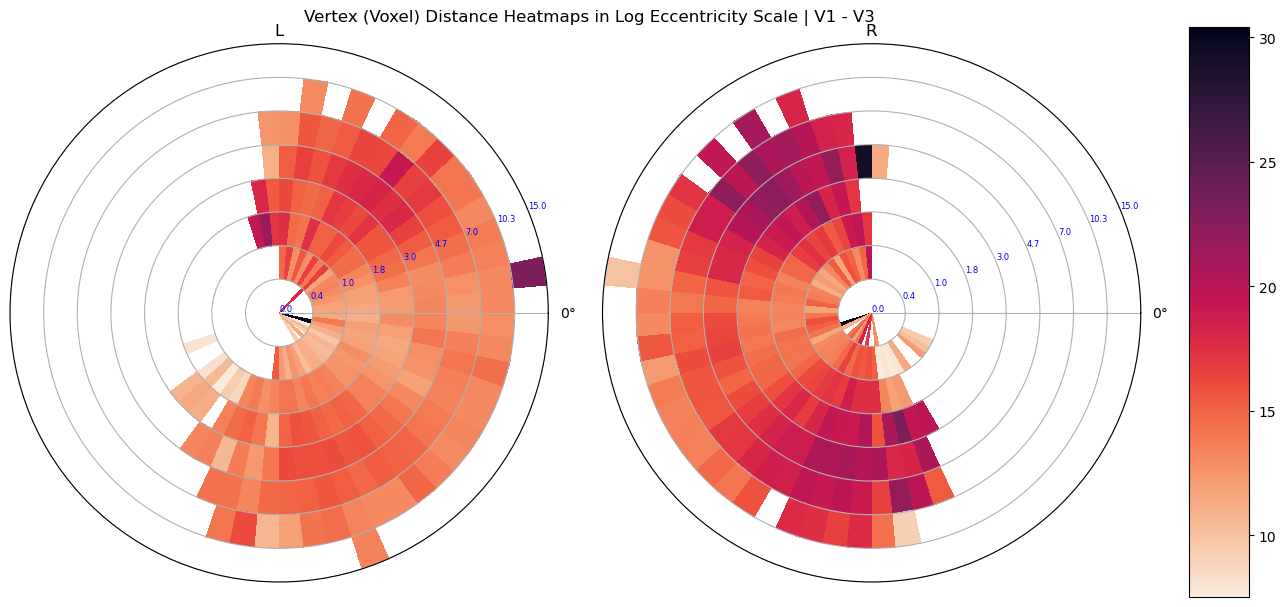

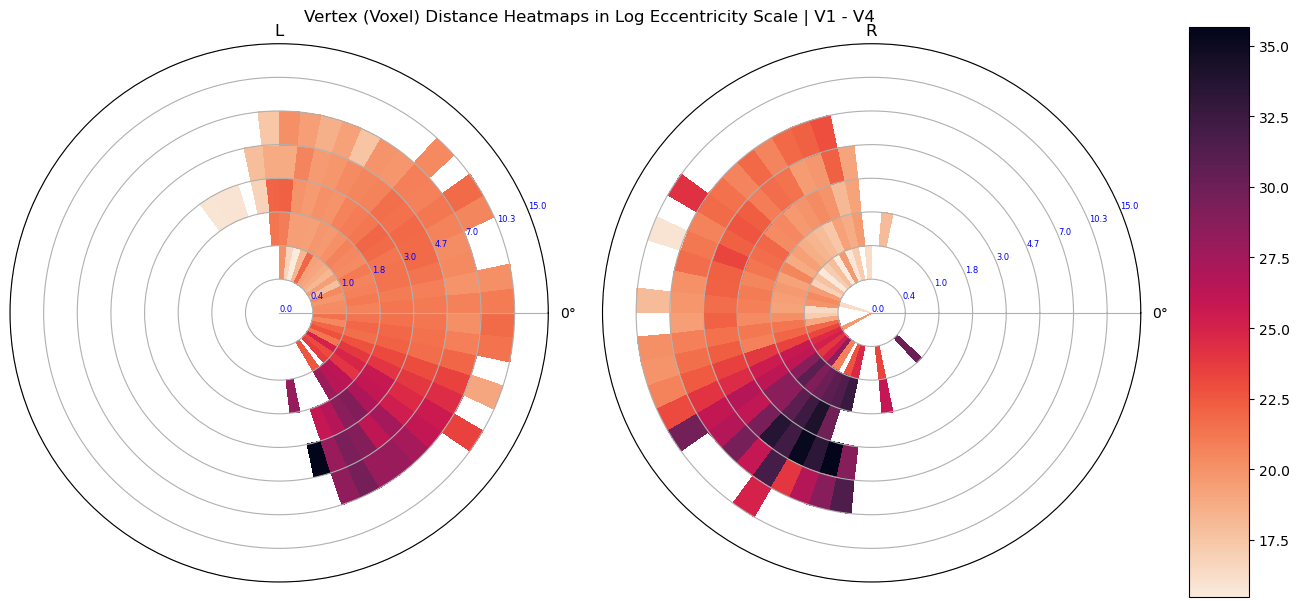

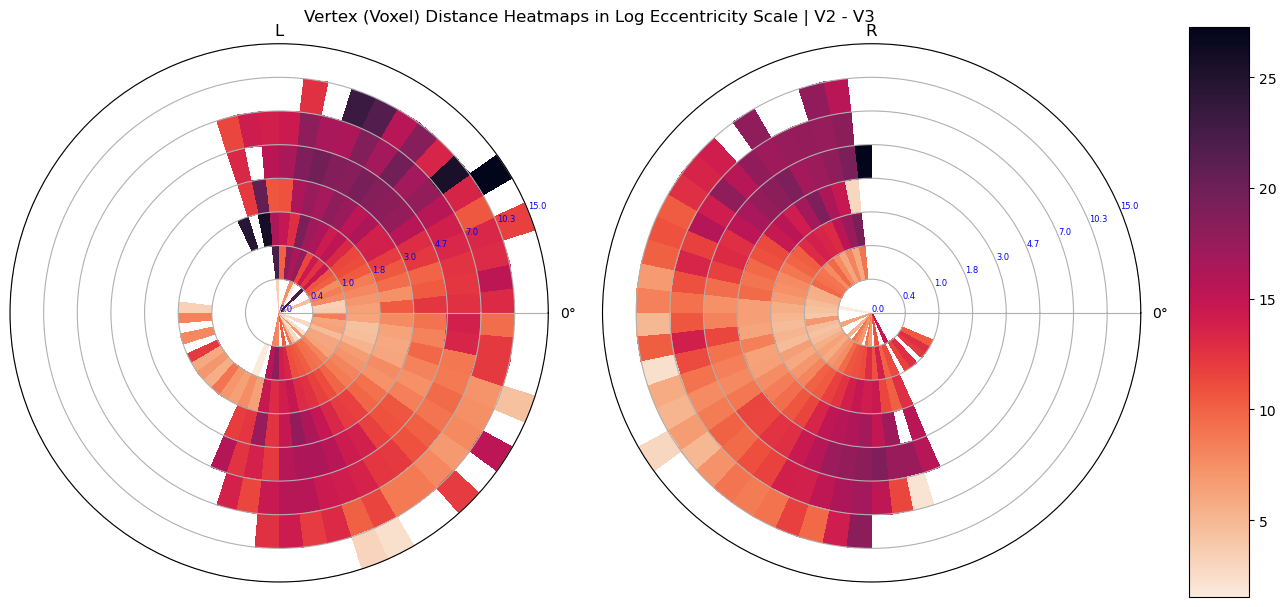

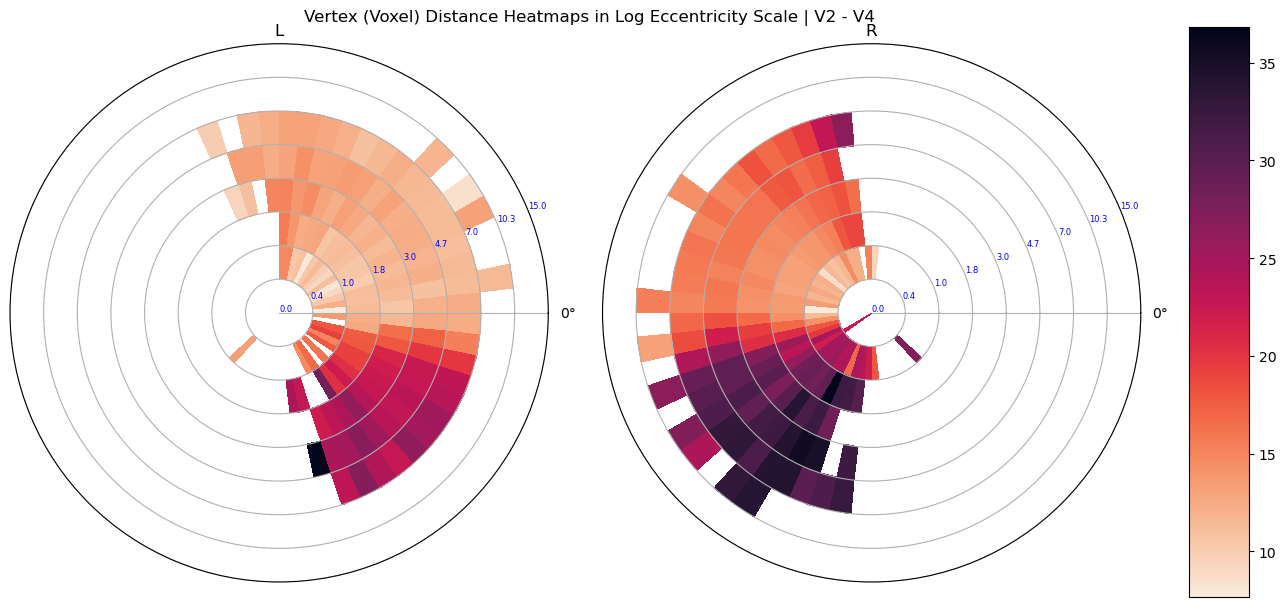

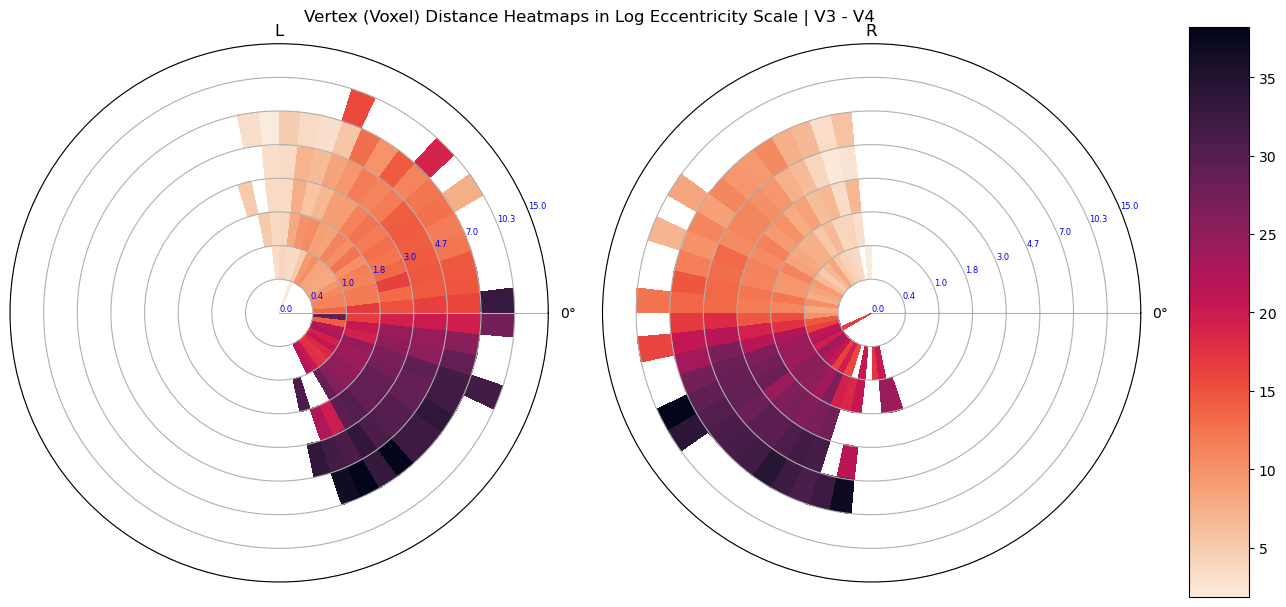

In [440]:
show(12)
show(13)
show(14)
show(23)
show(24)
show(34)

In [438]:
dfv_l_d_s = sum([i.fillna(0) for i in [dfv_l_d_12, dfv_l_d_13, dfv_l_d_14, dfv_l_d_23, dfv_l_d_24, dfv_l_d_34]]).replace({0: np.nan})/6
dfv_r_d_s = sum([i.fillna(0) for i in [dfv_r_d_12, dfv_r_d_13, dfv_r_d_14, dfv_r_d_23, dfv_r_d_24, dfv_r_d_34]]).replace({0: np.nan})/6

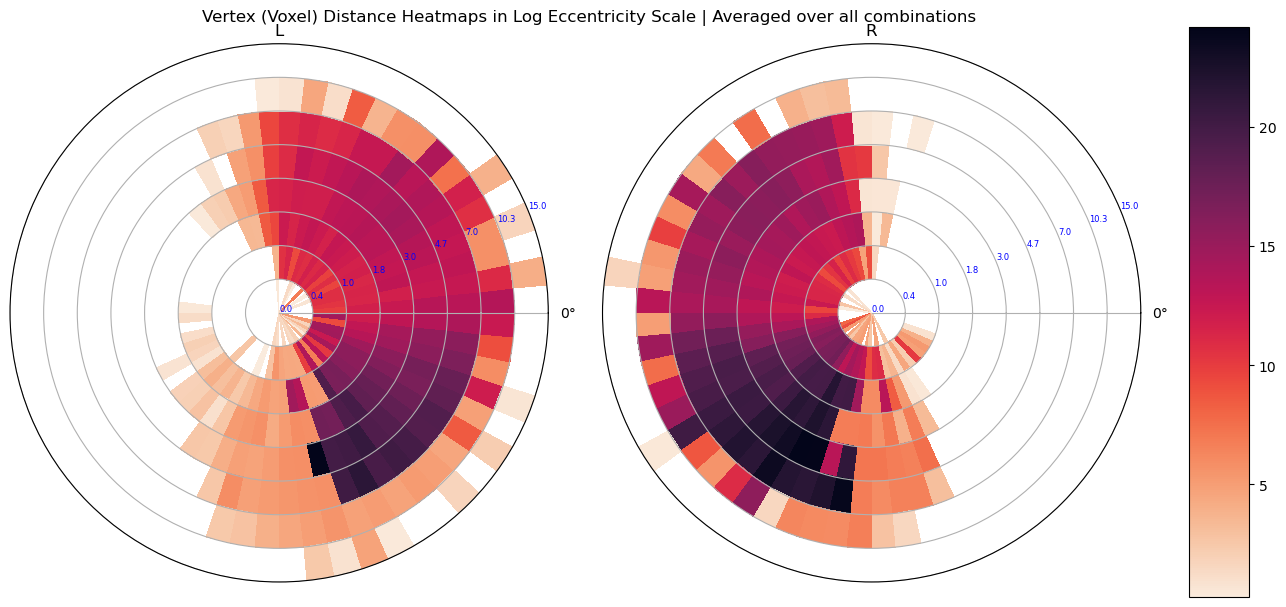

In [445]:
show([dfv_l_d_s, dfv_r_d_s], label='Averaged over all combinations')

---

In [73]:
# TODO:
## Aggregate on ang and plot on ecc.

---

In [74]:
# TODO:
## Distance calculations based on nearest centroid classification.

In [75]:
dfv1 = dfv.loc[(df_['sid'] == I) & dfv[label].str.contains('V1')]
dfv2 = dfv.loc[(df_['sid'] == I) & dfv[label].str.contains('V2')]

In [76]:
v1 = dfv1[['x', 'y', 'z']].to_numpy()
v2 = dfv2[['x', 'y', 'z']].to_numpy()

---